### imports

In [763]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from pymonntorch import (
      NeuronDimension,
      Behavior, 
      Network, 
      Recorder,
      EventRecorder,
      NeuronGroup,
      SynapseGroup
)

from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    SpikeTrace,
    NeuronAxon,
    Fire,
)
from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    WeightClip,
    SimpleDendriticInput,
    SimpleSTDP,
)


### params

In [764]:
DEVICE = "cpu"
DTYPE = torch.float32
DT = 1


RES = 5.0
THR = -50.
TAU = 10.
V_RESET = -75.
V_REST = -67.
TRACE_TAU = 17.

ITER = 1000
TIMES_500 = ITER//500
EXC_SIZE1 = 10
EXC_SIZE2 = 2

torch.manual_seed(42)

### pattern

In [765]:
# x1 = torch.tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0]).float()
# x2 = x1.flip(0)
x1 = torch.tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0]).float()
x2 = torch.tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0]).float()
x3 = torch.Tensor(10).float()
pattern1 = []
for _ in range(TIMES_500*2):
    for i in range(250):
        if (i > 100 and i < 150):
            pattern1.append(x3)
        elif (i > 100):
            pattern1.append(x2)
        else:
            pattern1.append(x1)
pattern1 = torch.stack(pattern1)
pattern1.shape

torch.Size([1000, 10])

### LIF

In [766]:
class LIF_input(Behavior):

    def initialize(self, neurons):
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)
        self.set_parameters_as_variables(neurons)

        neurons.v = self.parameter("init_v", neurons.vector(mode='zeros'))
        neurons.spikes = self.parameter("init_s", neurons.v >= neurons.threshold)

        neurons.spiking_neuron = self

    def _RIu(self, neurons):
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        neurons.spikes = neurons.spike_iter[neurons.iteration-1].bool()
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )

In [767]:
class LIF_output(Behavior):
    def initialize(self, neurons):
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)

        neurons.v = self.parameter("init_v", neurons.vector(mode='zeros'))
        neurons.spikes = self.parameter("init_s", neurons.v >= neurons.threshold)

        neurons.spiking_neuron = self

    def _RIu(self, neurons):
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )

### Dendrite

In [768]:
class Dendrite(Behavior):
    def forward(self, neurons):
        neurons.I = neurons.vector(mode=0)
        for synapse in neurons.afferent_synapses['Proximal']:
            neurons.I += synapse.I

In [769]:
class BaseDendriticInput(Behavior):
    """
    Base behavior for turning pre-synaptic spikes to post-synaptic current. It checks for excitatory/inhibitory attributes
    of pre-synaptic neurons and sets a coefficient accordingly.

    Note: weights must be initialize by others behaviors.
          Also, Axon paradigm should be added to the neurons.
          Connection type (Proximal, Distal, Apical) should be specified by the tag
          of the synapse. and Dendrite behavior of the neurons group should access the
          `I` of each synapse to apply them.

    Args:
        current_coef (float): Scalar coefficient that multiplies weights.
    """

    def __init__(self, *args, current_coef=1, **kwargs):
        super().__init__(*args, current_coef=current_coef, **kwargs)

    def initialize(self, synapse):
        """
        Sets the current_type to -1 if the pre-synaptic neurons are inhibitory.

        Args:
            current_coef (float): Strength of the synapse.
        """
        synapse.add_tag(self.__class__.__name__)
        self.current_coef = self.parameter("current_coef", 1)

        self.current_type = (
            -1 if ("GABA" in synapse.src.tags) or ("inh" in synapse.src.tags) else 1
        )

        self.def_dtype = synapse.def_dtype
        synapse.I = synapse.dst.vector(0)

    def calculate_input(self, synapse):
        ...

    def forward(self, synapse):
        synapse.I = (
            self.current_coef * self.current_type * self.calculate_input(synapse)
        )
        
class MyLateralDendriticInput(BaseDendriticInput):
    """
    Lateral dendrite behavior.

    Note: weight shape = (1, 1, kernel_depth, kernel_height, kernel_width)
          weights must be initialize by others behaviors.
          Also, Axon paradigm should be added to the neurons.
          Connection type (Proximal, Distal, Apical) should be specified by the tag
          of the synapse. and Dendrite behavior of the neurons group should access the
          `I` of each synapse to apply them.

    Args:
        current_coef (float): Scalar coefficient that multiplies weights.
        inhibitory (bool or None): If None, connection type respect the NeuronGroup type. if True, the effect in inhibitory and False is excitatory.
    """

    def __init__(self, *args, current_coef=1, inhibitory=None, **kwargs):
        super().__init__(
            *args, current_coef=current_coef, inhibitory=inhibitory, **kwargs
        )

    def initialize(self, synapse):
        super().initialize(synapse)
        ctype = self.parameter("inhibitory", None)

        #self.padding = tuple(((synapse.weights.shape[i] - 1) // 2) for i in range(2, 5))
        if ctype is not None:
            self.current_type = ctype * -2 + 1
    
        if synapse.src != synapse.dst:
            raise RuntimeError(
                f"Synapse {synapse.src.tags[0]}=>{synapse.dst.tags[0]}: For lateral connection src and dst neuron group should be same"
            )

        # if not synapse.weights.numel() % 2:
        #     raise RuntimeError(
        #         f"Synapse {synapse.src.tags[0]}=>{synapse.dst.tags[0]}: For lateral connection weight should not have any even size dimension. {synapse.weights.shape}"
        #     )

    def calculate_input(self, synapse):
        spikes = synapse.src.axon.get_spike(synapse.src, synapse.src_delay).to(
            self.def_dtype
        )
        spikes = spikes.view(1, *synapse.src_shape)
        spikes = torch.nn.functional.pad(spikes, (1, 1), "constant", 0)
        I = torch.nn.functional.conv2d(input=spikes, weight=synapse.weights, padding='same')
        return I.view((-1,))


In [770]:
class NoiseCurrent(Behavior):
    def initialize(self,ng):
        self.value = self.parameter('value', None)
        self.limit = self.parameter('limit', 1)
        self.rate = self.parameter('rate', 0.5)
        ng.I = ng.vector(mode=self.value)
    
    def forward(self, ng):
        if(np.random.random() < self.rate):
            rnd = round(np.random.normal(0, 1)) * self.limit
            x = ng.I + rnd < 0
            if sum(x) == 0:
                ng.I += rnd
            else:
                ng.I -= rnd

### Network

In [771]:
class TimeResolution(Behavior):
    def initialize(self, net):
        net.dt = self.parameter('dt', 1)
        net.t_passed = 0
        
net = Network(behavior={1: TimeResolution(dt=1)}, device=DEVICE, dtype=DTYPE)

In [772]:
ng1 = NeuronGroup(
    net=net,
    size=NeuronDimension(height=EXC_SIZE1),
    behavior={
            3: NoiseCurrent(value=0, limit=0.01, rate=0.5),
            5: LIF_input(
                spike_iter = pattern1,
                R=RES,
                threshold=THR,
                tau=TAU,
                v_reset=V_RESET,
                v_rest=V_REST,
            ),
            6: Fire(),
            7: SpikeTrace(tau_s=TRACE_TAU),
            8: NeuronAxon(),
            11: Recorder(tag='ng1_rec', variables=['I', 'v']),
            12: EventRecorder(tag='ng1_eventrec', variables=['spikes'])},
)

ng2 = NeuronGroup(
    net=net,
    size=NeuronDimension(height=EXC_SIZE2),
    behavior={
            3:SimpleDendriteStructure(),
            4:SimpleDendriteComputation(I_tau=1),
            5: LIF_output(
                R=RES,
                threshold=THR,
                tau=TAU,
                v_reset=V_RESET,
                v_rest=V_REST,
            ),
            6: Fire(),
            7: SpikeTrace(tau_s=TRACE_TAU),
            8: NeuronAxon(),
            11: Recorder(tag='ng2_rec', variables=['I', 'v']),
            12: EventRecorder(tag='ng2_eventrec', variables=['spikes']),
    }
)

In [773]:
syn1 = SynapseGroup(
    net=net,
    src=ng1,
    dst=ng2,
    behavior={
            1: SynapseInit(),
            2: WeightInitializer(mode='normal(0.2, 0.1)'),
            3: SimpleDendriticInput(current_coef=40),
            4: SimpleSTDP(a_plus=0.009, a_minus=0.008, positive_bound='soft_bound', negative_bound='soft_bound'),
            5: WeightClip(w_max=1., w_min=0.),
            9: Recorder(['weights']),
    },
    tag="Proximal",
)

syn2 = SynapseGroup(
    net=net,
    src=ng2,
    dst=ng2,
    behavior={
            1: SynapseInit(),
            2: WeightInitializer(mode='normal(0.4, 0.1)', weight_shape=(1, 1, EXC_SIZE2, EXC_SIZE2)),
            3: MyLateralDendriticInput(current_coef=40, inhibitory=True),
            4: SimpleSTDP(a_plus=0.009, a_minus=0.008, positive_bound='soft_bound', negative_bound='soft_bound'),
            5: WeightClip(w_max=1., w_min=0.01),
            9: Recorder(['weights']),
    },
    tag="Proximal",
)

net.initialize()
net.simulate_iterations(ITER)

Network['Network'](Neurons: tensor(12)|2 groups, Synapses: tensor(24)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](10){0:NeuronDimension(depth=1,height=10,width=1,input_patterns=None,)3:NoiseCurrent(value=0,limit=0.01,rate=0.5,)5:LIF_input(spike_iter=tensor([[0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]]),R=5.0,threshold=-50.0,tau=10.0,v_reset=-75.0,v_rest=-67.0,)6:Fire()7:SpikeTrace(tau_s=17.0,)8:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)11:Recorder(variables=['I', 'v'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec,)12:EventRecorder(variables=['spikes'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_eventrec,)}
NeuronGroup['NeuronGroup_2', 'NeuronGroup', 'ng'](2){0:NeuronDim

501.77526473999023

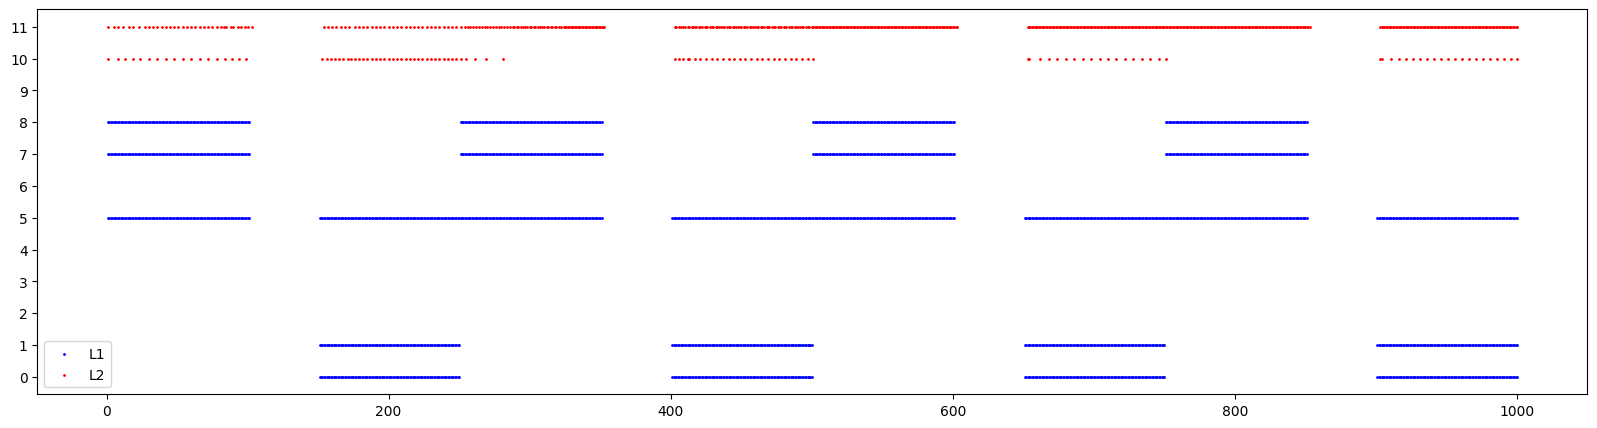

In [774]:
plt.figure(figsize=(20,5))
plt.scatter(net['ng1_eventrec', 0].variables['spikes'][:, 0], net['ng1_eventrec', 0].variables['spikes'][:, 1], color='blue', s=1, label='L1')
plt.scatter(net['ng2_eventrec', 0].variables['spikes'][:, 0], net['ng2_eventrec', 0].variables['spikes'][:, 1]+EXC_SIZE1, color='red', s=1, label='L2')
plt.yticks(range(EXC_SIZE1+EXC_SIZE2))
plt.legend()
plt.show()

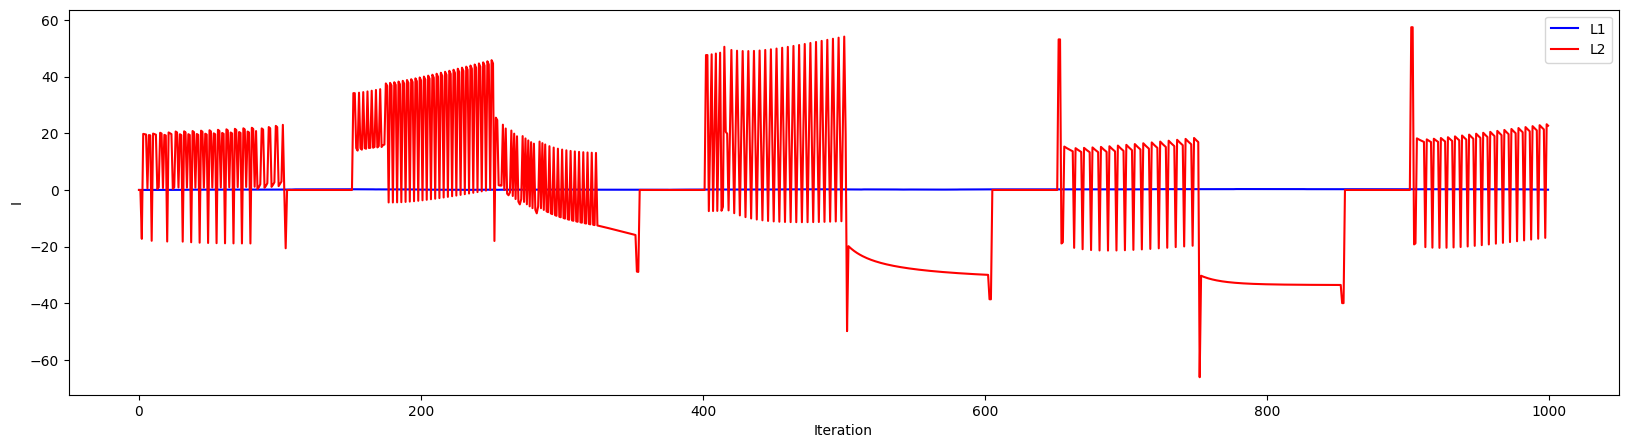

In [775]:
plt.figure(figsize=(20,5))
plt.plot(net['ng1_rec', 0].variables['I'][:,:1], color='blue', label='L1')
plt.plot(net['ng2_rec', 0].variables['I'][:,:1], color='red', label='L2')
plt.ylabel('I')
plt.xlabel('Iteration')
plt.legend()
plt.show()

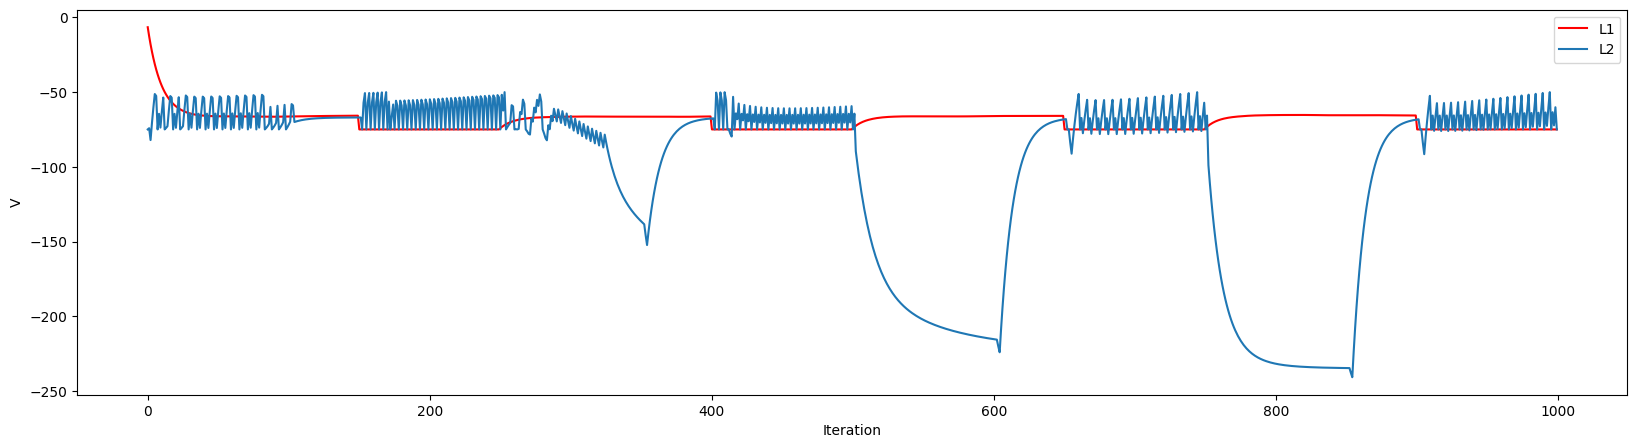

In [776]:
plt.figure(figsize=(20,5))
plt.plot(net['ng1_rec', 0].variables['v'][:,:1], color='red', label='L1')
plt.plot(net['ng2_rec', 0].variables['v'][:,:1], label='L2')
plt.ylabel('V')
plt.xlabel('Iteration')
plt.legend()
plt.show()

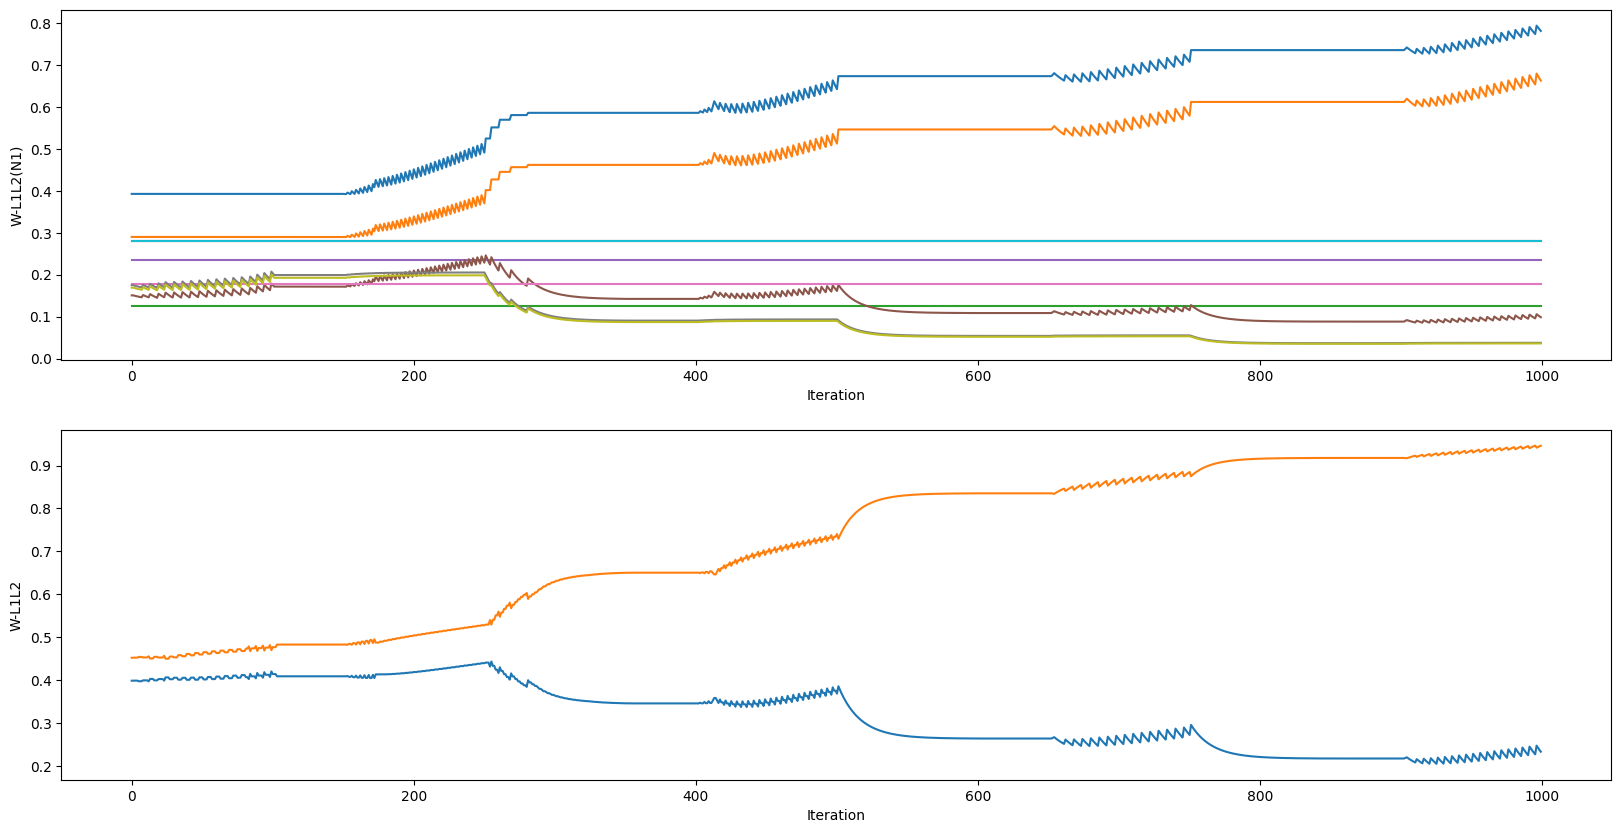

In [777]:
fig, axs = plt.subplots(2, figsize=(20,10))
time = np.arange(0, ITER, 1)

axs[0].plot(range(ITER), syn1['weights', 0][:, :, 0])
axs[0].set(xlabel="Iteration", ylabel="W-L1L2(N1)")

axs[1].plot(range(ITER), syn2['weights', 0][:,0,0,1,0])
axs[1].plot(range(ITER), syn2['weights', 0][:,0,0,0,1])
axs[1].set(xlabel='Iteration', ylabel="W-L1L2")
plt.show()